In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import wandb

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02514/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(0,1),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(30),
                                    ])
test_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor(), 
                                      transforms.Normalize(0,1)])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=3)

Let's look at some images from our data 

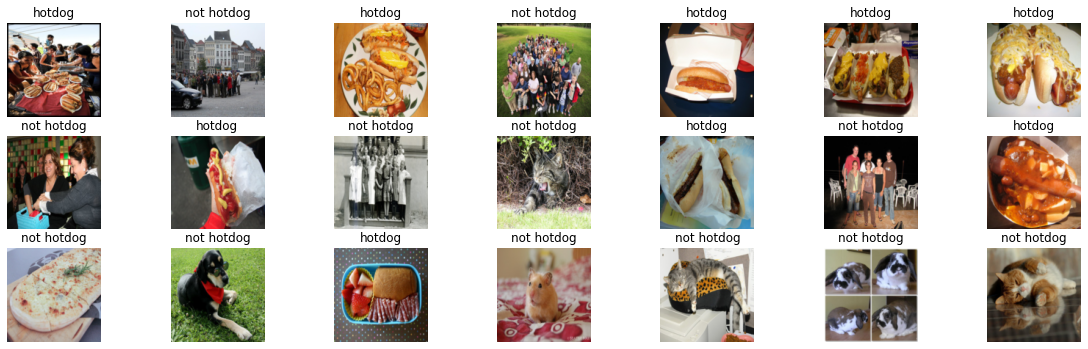

In [5]:
images, labels = next(iter(test_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

Now create a model and train it!


In [6]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        loss = nn.CrossEntropyLoss()
        return loss(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    patience = 0
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):        
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
        
             
        
        if out_dict['test_loss'][-1] > min(out_dict['test_loss']):
            patience += 1 
        else: 
            patience = 0
            
        if patience == 7:
            print("EARLY STOPPED!")
            break 
       
    return out_dict

In [7]:
model_SGD = models.resnet18(pretrained=False)
num_ftrs = model_SGD.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_SGD.fc = nn.Linear(num_ftrs, 2)

model_ADAM = models.resnet18(pretrained=False)
num_ftrs = model_ADAM.fc.in_features
model_ADAM.fc = nn.Linear(num_ftrs, 2)

model_pre_SGD = models.resnet18(pretrained=True)
num_ftrs = model_pre_SGD.fc.in_features
model_pre_SGD.fc = nn.Linear(num_ftrs, 2)

model_pre_ADAM = models.resnet18(pretrained=True)
num_ftrs = model_pre_ADAM.fc.in_features
model_pre_ADAM.fc = nn.Linear(num_ftrs, 2)

model_SGD.to(device)
model_ADAM.to(device)
model_pre_SGD.to(device)
model_pre_ADAM.to(device)

#Initialize the optimizer
SGD_lr = 0.001
ADAM_lr = 0.000005
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=SGD_lr)
optimizer_ADAM = torch.optim.Adam(model_ADAM.parameters(),lr=ADAM_lr)

#Initialize the optimizer
pre_SGD_lr = 0.001
pre_ADAM_lr = 0.00001
optimizer_pre_SGD = torch.optim.SGD(model_pre_SGD.parameters(), lr=pre_SGD_lr)
optimizer_pre_ADAM = torch.optim.Adam(model_pre_ADAM.parameters(),lr=pre_ADAM_lr)

num_epoch = 30

  0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.698	 test: 0.694	 Accuracy train: 50.9%	 test: 49.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.681	 test: 0.696	 Accuracy train: 55.6%	 test: 52.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.674	 test: 0.676	 Accuracy train: 59.1%	 test: 57.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.657	 test: 0.671	 Accuracy train: 62.1%	 test: 59.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.650	 test: 0.661	 Accuracy train: 63.6%	 test: 60.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.637	 test: 0.650	 Accuracy train: 64.3%	 test: 64.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.629	 test: 0.652	 Accuracy train: 65.9%	 test: 62.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.619	 test: 0.632	 Accuracy train: 66.0%	 test: 65.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.613	 test: 0.641	 Accuracy train: 67.3%	 test: 64.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.606	 test: 0.627	 Accuracy train: 68.8%	 test: 66.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.600	 test: 0.616	 Accuracy train: 69.2%	 test: 67.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.597	 test: 0.629	 Accuracy train: 70.0%	 test: 66.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.587	 test: 0.622	 Accuracy train: 69.8%	 test: 68.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.582	 test: 0.602	 Accuracy train: 71.4%	 test: 70.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.583	 test: 0.604	 Accuracy train: 70.9%	 test: 69.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.578	 test: 0.598	 Accuracy train: 70.7%	 test: 70.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.568	 test: 0.587	 Accuracy train: 71.7%	 test: 71.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.566	 test: 0.582	 Accuracy train: 72.2%	 test: 70.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.559	 test: 0.577	 Accuracy train: 73.1%	 test: 72.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.554	 test: 0.583	 Accuracy train: 74.3%	 test: 71.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.545	 test: 0.579	 Accuracy train: 74.6%	 test: 71.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.540	 test: 0.563	 Accuracy train: 74.6%	 test: 72.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.531	 test: 0.559	 Accuracy train: 75.1%	 test: 72.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.524	 test: 0.606	 Accuracy train: 76.0%	 test: 69.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.521	 test: 0.553	 Accuracy train: 76.3%	 test: 74.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.506	 test: 0.547	 Accuracy train: 76.7%	 test: 73.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.507	 test: 0.605	 Accuracy train: 77.0%	 test: 66.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.503	 test: 0.533	 Accuracy train: 77.0%	 test: 75.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.499	 test: 0.532	 Accuracy train: 77.2%	 test: 74.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.494	 test: 0.553	 Accuracy train: 77.1%	 test: 74.8%


  0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.726	 test: 0.688	 Accuracy train: 47.8%	 test: 52.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.670	 test: 0.650	 Accuracy train: 55.9%	 test: 62.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.638	 test: 0.631	 Accuracy train: 64.3%	 test: 66.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.611	 test: 0.623	 Accuracy train: 68.0%	 test: 67.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.595	 test: 0.600	 Accuracy train: 68.9%	 test: 68.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.584	 test: 0.593	 Accuracy train: 71.0%	 test: 70.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.562	 test: 0.580	 Accuracy train: 72.7%	 test: 70.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.551	 test: 0.566	 Accuracy train: 73.3%	 test: 71.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.532	 test: 0.553	 Accuracy train: 73.9%	 test: 73.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.522	 test: 0.540	 Accuracy train: 74.7%	 test: 74.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.505	 test: 0.553	 Accuracy train: 75.9%	 test: 73.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.503	 test: 0.526	 Accuracy train: 76.5%	 test: 74.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.485	 test: 0.536	 Accuracy train: 76.7%	 test: 74.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.471	 test: 0.527	 Accuracy train: 77.1%	 test: 74.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.468	 test: 0.523	 Accuracy train: 78.1%	 test: 74.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.469	 test: 0.539	 Accuracy train: 78.2%	 test: 74.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.459	 test: 0.522	 Accuracy train: 79.5%	 test: 75.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.451	 test: 0.515	 Accuracy train: 78.9%	 test: 75.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.447	 test: 0.525	 Accuracy train: 79.9%	 test: 75.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.446	 test: 0.529	 Accuracy train: 79.8%	 test: 74.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.438	 test: 0.510	 Accuracy train: 80.3%	 test: 75.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.447	 test: 0.517	 Accuracy train: 80.1%	 test: 75.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.435	 test: 0.509	 Accuracy train: 80.6%	 test: 75.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.430	 test: 0.510	 Accuracy train: 81.5%	 test: 75.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.429	 test: 0.517	 Accuracy train: 80.5%	 test: 76.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.433	 test: 0.501	 Accuracy train: 80.2%	 test: 75.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.418	 test: 0.501	 Accuracy train: 81.1%	 test: 76.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.416	 test: 0.515	 Accuracy train: 82.3%	 test: 75.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.426	 test: 0.503	 Accuracy train: 81.8%	 test: 76.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.422	 test: 0.498	 Accuracy train: 80.9%	 test: 75.9%


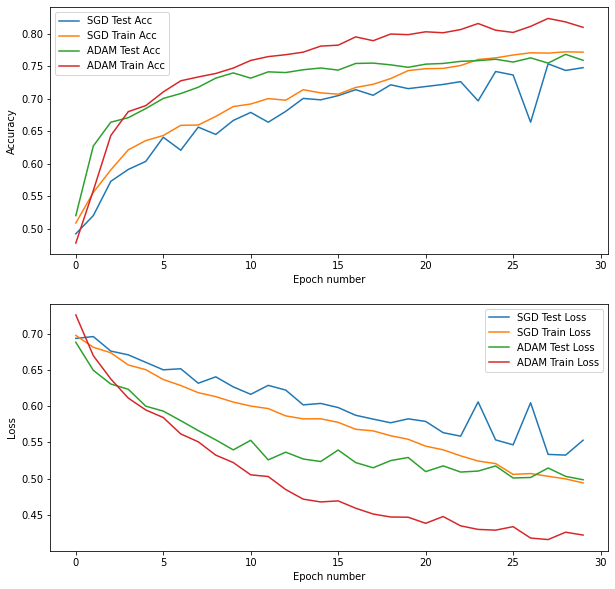

In [9]:
#wandb.init(project="Hotdog", name="SGD", entity="gizemggungor")


out_dict = train(model_SGD, optimizer_SGD, num_epoch)
fig, ax = plt.subplots(2,1,figsize=(10, 10))
ax[0].plot(out_dict["test_acc"], label='SGD Test Acc')
ax[0].plot(out_dict["train_acc"], label='SGD Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')


ax[1].plot(out_dict["test_loss"], label='SGD Test Loss')
ax[1].plot(out_dict["train_loss"], label='SGD Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')

#
out_dict = train(model_ADAM, optimizer_ADAM, num_epoch)
ax[0].plot(out_dict["test_acc"], label='ADAM Test Acc')
ax[0].plot(out_dict["train_acc"], label='ADAM Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(out_dict["test_loss"], label='ADAM Test Loss')
ax[1].plot(out_dict["train_loss"], label='ADAM Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
ax[1].legend()

In [8]:





out_dict = train(model_pre_ADAM, optimizer_pre_ADAM, num_epoch)
ax[0].plot(out_dict["test_acc"], label='ADAM Test Acc')
ax[0].plot(out_dict["train_acc"], label='ADAM Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(out_dict["test_loss"], label='ADAM Test Loss')
ax[1].plot(out_dict["train_loss"], label='ADAM Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
ax[1].legend()

  0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.587	 test: 0.473	 Accuracy train: 69.1%	 test: 78.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.408	 test: 0.382	 Accuracy train: 82.0%	 test: 83.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.344	 test: 0.360	 Accuracy train: 85.3%	 test: 85.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.303	 test: 0.305	 Accuracy train: 87.2%	 test: 87.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.272	 test: 0.295	 Accuracy train: 89.1%	 test: 88.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.264	 test: 0.279	 Accuracy train: 88.6%	 test: 89.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.228	 test: 0.273	 Accuracy train: 91.6%	 test: 89.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.216	 test: 0.257	 Accuracy train: 91.2%	 test: 90.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.202	 test: 0.242	 Accuracy train: 92.2%	 test: 90.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.193	 test: 0.236	 Accuracy train: 92.3%	 test: 90.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.179	 test: 0.235	 Accuracy train: 92.5%	 test: 90.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.179	 test: 0.233	 Accuracy train: 93.3%	 test: 90.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.169	 test: 0.229	 Accuracy train: 93.4%	 test: 91.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.147	 test: 0.230	 Accuracy train: 94.3%	 test: 91.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.165	 test: 0.231	 Accuracy train: 93.8%	 test: 90.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.135	 test: 0.221	 Accuracy train: 94.8%	 test: 91.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.137	 test: 0.233	 Accuracy train: 95.0%	 test: 91.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.120	 test: 0.215	 Accuracy train: 96.2%	 test: 91.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.120	 test: 0.231	 Accuracy train: 95.6%	 test: 91.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.118	 test: 0.213	 Accuracy train: 95.7%	 test: 91.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.106	 test: 0.247	 Accuracy train: 96.1%	 test: 91.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.101	 test: 0.223	 Accuracy train: 96.6%	 test: 91.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.103	 test: 0.215	 Accuracy train: 96.0%	 test: 91.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.092	 test: 0.230	 Accuracy train: 96.9%	 test: 91.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.092	 test: 0.210	 Accuracy train: 97.0%	 test: 91.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.080	 test: 0.224	 Accuracy train: 97.2%	 test: 91.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.076	 test: 0.245	 Accuracy train: 97.7%	 test: 91.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.075	 test: 0.217	 Accuracy train: 97.8%	 test: 91.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.075	 test: 0.209	 Accuracy train: 97.3%	 test: 91.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.067	 test: 0.227	 Accuracy train: 97.8%	 test: 91.2%


NameError: name 'ax' is not defined

In [9]:
#salicancy map

def m_c_hat(x,N,std=0.3):
    smooth = 0
    std /= torch.max(x) - torch.min(x)
    for i in range(N):
        smooth  =+ m_c(x + (torch.randn(x.size()) * std))
    return smooth / N

def m_c(x):
    x = x.to(device)
    x.requires_grad_()
    scores = model(x)

    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[0, score_max_index]

    score_max.backward()
    
    saliency, _ = torch.max(x.grad.data.abs(), dim=1) 
    return saliency

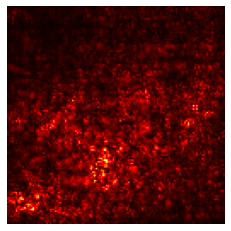

In [10]:
images, labels = next(iter(test_loader))

model = model_pre_ADAM
model.to(device)
model.eval()

X = images[0,:,:,:]
X = X[None,:,:,:]

saliency = m_c(X)

# code to plot the saliency map as a heatmap
plt.imshow(saliency[0].cpu(), cmap=plt.cm.hot)
plt.axis('off')
plt.show()


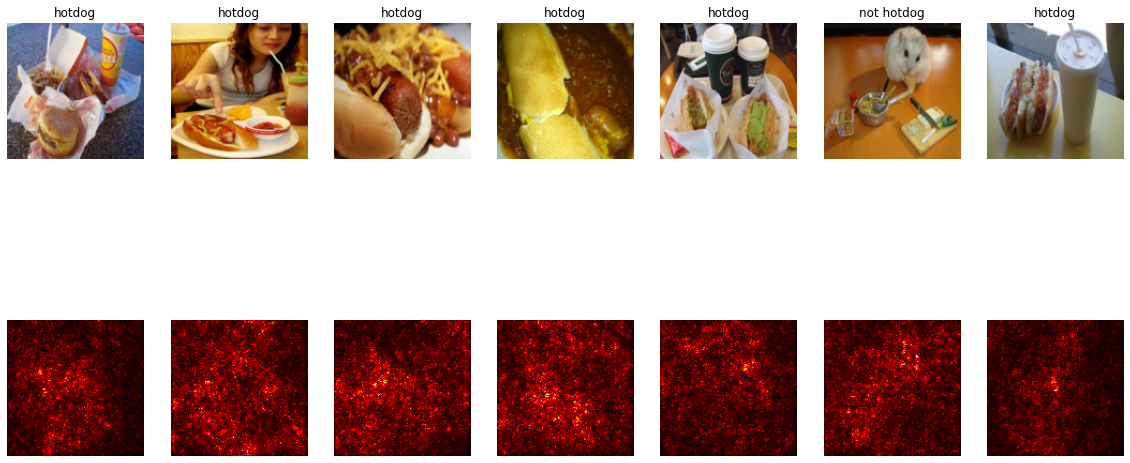

In [12]:

fig, axs = plt.subplots(2,7,figsize=(20,10))


images, labels = next(iter(test_loader))

model.to('cuda')
model.eval()

stds = [0.08,0.09,0.1,0.11,0.12,0.13,0.14]

for i in range(7):
    imgid = 40+i
    X = images[imgid,:,:,:]
    X = X[None,:,:,:]

    saliency = m_c_hat(X,10, 0.1)
    #saliency = m_c(X)
    
    axs[0,i].imshow(np.swapaxes(np.swapaxes(images[imgid].numpy(), 0, 2), 0, 1))
    axs[0,i].title.set_text(['hotdog', 'not hotdog'][labels[imgid].item()])
    #axs[0,i].title.set_text(stds[i])
    axs[1,i].axis('off')
    axs[0,i].axis('off')
    axs[1,i].imshow(saliency[0].cpu(), cmap=plt.cm.hot)
#     axs[1,i].imshow(saliency[0])
